# Tratamiento de señales (intro): de tiempo a frecuencia, filtrado y evaluación

## 1) Motivación
En sistemas físicos (péndulo, masa–resorte, meteorología, audio, vibraciones) las señales contienen **patrones periódicos** (p. ej., frecuencia natural o ciclo diurno) mezclados con **ruido**. Hoy aprenderemos a **estimar** esas frecuencias, **suavizar** el ruido sin introducir desfase y **evaluar** el efecto del filtrado.

---

## 2) Objetivo de la sesión
Al finalizar, podrás:
1. Estimar la **frecuencia (o período) dominante** de una señal real mediante **PSD de Welch**.
2. Diseñar y aplicar un **filtro pasa–bajo Butterworth** con **fase cero** (via `filtfilt`).
3. Comparar **señal cruda vs. filtrada** en el **tiempo** y en la **frecuencia**, cuantificando SNR y reducción de varianza.

---

## 3) Conceptos y ecuaciones clave

### Muestreo y notación
- Señal discreta: $x[n]=x(nT_s)$, con $T_s=1/f_s$ y **Nyquist** $f_N=\tfrac{f_s}{2}$. (https://en.wikipedia.org/wiki/Nyquist_frequency)
- Vector de tiempos: $t_n=nT_s$.

### FFT y DFT (idea base del espectro)
La **Transformada Discreta de Fourier** (DFT) de una ventana de $N$ puntos es
$$
X[k]=\sum_{n=0}^{N-1} x[n]\,e^{-j2\pi kn/N},\qquad f_k=\frac{k}{N}f_s.
$$
El **periodograma** estima la potencia espectral:
$$
P_{\text{per}}(f_k)=\frac{1}{Nf_s}\,\bigl|X[k]\bigr|^2.
$$

### PSD con Welch (estabilidad espectral)
En el contexto de las señales, PSD significa Densidad Espectral de Potencia (Power Spectral Density), que es una medida de cómo se distribuye la potencia de una señal a lo largo de las diferentes frecuencias. Funciona como un gráfico en el dominio de la frecuencia que muestra la potencia por unidad de Hertz, siendo muy útil para analizar y caracterizar señales aleatorias de banda ancha, como vibraciones y ruido. 

Welch promedia periodogramas de segmentos solapados y **ventaneados** (Hann, etc.):
$$
\widehat{S}_{xx}(f)=\frac{1}{L}\sum_{\ell=1}^{L} P_{\text{per}}^{(\ell)}(f).
$$
Ventanas reducen la **fuga espectral** (trade-off: resolución vs. varianza).

### Filtro pasa-bajo Butterworth (magnitud maximálmente plana)
Filtro IIR de orden $N$ con frecuencia de corte digital $W_n=\frac{f_c}{f_N}$.
Magnitud idealizada (analógica) de Butterworth:
$$
\left|H(j\Omega)\right|^2=\frac{1}{1+\left(\frac{\Omega}{\Omega_c}\right)^{2N}}.
$$
En práctica diseñamos $b,a=\text{butter}(N,W_n,\text{'low'})$ y aplicamos
$$
y=\text{filtfilt}(b,a,x),
$$
que realiza filtrado adelante-atrás ⇒ **fase cero** (sin desfase de grupo).

### Métricas de evaluación
- **Frecuencia dominante** $f_0=\arg\max_f \widehat{S}_{xx}(f)$, **período** $T_0=1/f_0$.
- **Relación señal-ruido (SNR)** en banda $B$ alrededor de $f_0$:
$$
\mathrm{SNR}=\frac{\int_{f_0-\Delta}^{f_0+\Delta} \widehat{S}_{xx}(f)\,df}
{\int_{F\setminus B} \widehat{S}_{xx}(f)\,df}.
$$
- **Reducción de varianza** por filtrado:
$$
\Delta \sigma = \sigma(x)-\sigma(y), \qquad \text{con } y=\text{señal filtrada}.
$$

> Regla práctica: elegir $f_c$ **por encima** de $f_0$ (p. ej., $1.5\!-\!2\times f_0$) para conservar el modo físico y atenuar alta frecuencia.

---

## 4) Flujo práctico de hoy

1. **Generar o cargar una señal** $x(t)$ (sintética o real).
2. **Preprocesar**: quitar media (demean), **detrend** lineal y **ventana Hann** para el análisis espectral.
3. **Estimar PSD (Welch)** y **ubicar $f_0$** y posibles armónicos.
4. **Diseñar** Butterworth pasa-bajo (orden 4, $f_c$ guiado por $f_0$) y **aplicar `filtfilt`**.
5. **Comparar**:
   - En **tiempo**: $x(t)$ vs. $y(t)$.
   - En **frecuencia**: $\widehat{S}_{xx}(f)$ antes/después.
   - **Métricas**: $f_0,\,T_0,\,\mathrm{SNR},\,\Delta\sigma$.

---

## 5) Qué entregas hoy
- **Figura 1**: señal cruda vs. filtrada (ejes y leyenda claros).
- **Figura 2**: PSD (Welch) antes vs. después (eje en Hz o ciclos/día).
- **Mini-informe (5–7 líneas)** con $f_s$, $f_0$, $T_0$, $f_c$, SNR y una interpretación física breve.

> Extensión opcional: estimar **retardo** entre dos variables (p. ej., Temp↔Viento) con **correlación cruzada** y/o **coherencia** espectral.


## Para trabajar con datos reales: los datos....
Los datos "reales" de experimento vamos a tomaros desde https://meteostat.net/es/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ---------- 1) Señal de prueba ----------
fs = 200.0          # Hz (frecuencia de muestreo)
T  = 10.0           # s (duración)
t  = np.arange(0, T, 1/fs)

f0 = 2.0            # Hz (frecuencia "física" dominante)
x_clean = 0.8*np.sin(2*np.pi*f0*t) + 0.3*np.sin(2*np.pi*4*f0*t)  # fundamental + armónico
ruido = 0.6*np.random.randn(len(t))
x = x_clean + ruido

In [2]:
# ---------- 2) Preprocesado ----------
x = x - np.mean(x)                    # demean
x = signal.detrend(x, type='linear')  # detrend
win = signal.windows.hann(len(x))     # ventana Hann para FFT "de muestra"
xw  = x * win

In [3]:
# ---------- 3) Espectro (Welch) ----------
# Welch da PSD estable: segmenta, ventana y promedia
f, Pxx = signal.welch(x, fs=fs, nperseg=1024 if len(x)>=1024 else len(x)//2, window='hann')
f_filt, Pxx_filt = f.copy(), Pxx.copy()  # placeholder para luego

In [4]:
# Estimar pico de frecuencia
idx_peak = np.argmax(Pxx)
f_est = f[idx_peak]
print(f"Frecuencia dominante estimada (Welch): {f_est:.3f} Hz")

Frecuencia dominante estimada (Welch): 1.953 Hz


In [5]:
# ---------- 4) Filtrado pasa-bajo ----------
fc = 3.5  # Hz (elige según tu f_est; por ejemplo 1.5–2.0 * f0 si hay armónicos/ruido)
Wn = fc/(fs/2)  # frecuencia normalizada
b, a = signal.butter(N=4, Wn=Wn, btype='low', analog=False)
x_filt = signal.filtfilt(b, a, x)  # sin desfase
# PSD tras filtrar
f2, Pxx2 = signal.welch(x_filt, fs=fs, nperseg=1024 if len(x)>=1024 else len(x)//2, window='hann')

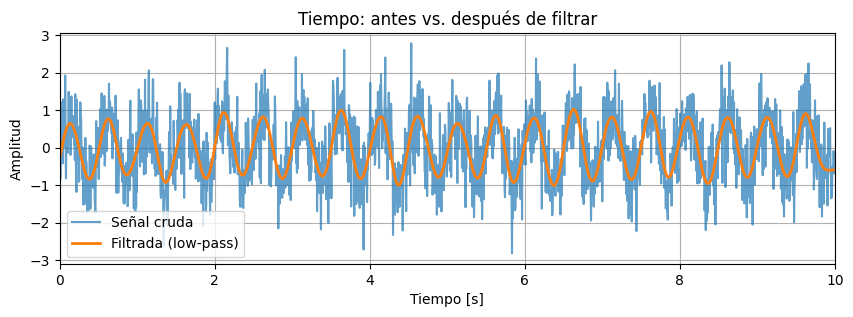

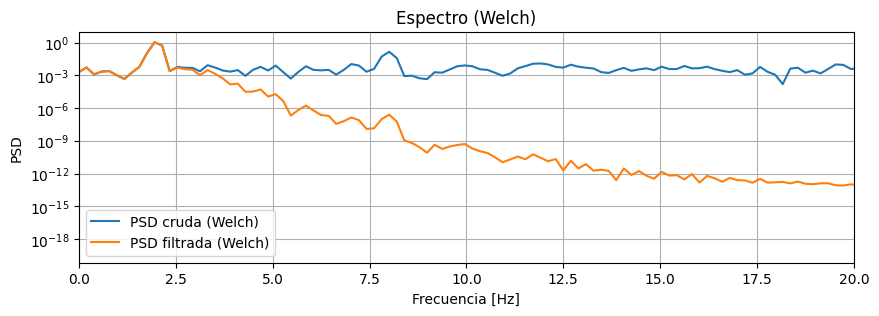

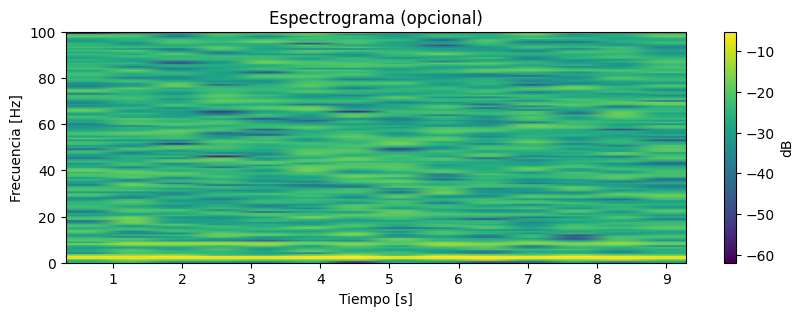

In [6]:
# ---------- 5) Visualizaciones ----------
plt.figure(figsize=(10,3))
plt.plot(t, x, label='Señal cruda', alpha=0.7)
plt.plot(t, x_filt, label='Filtrada (low-pass)', linewidth=2)
plt.xlim(0, 10)  # acercar primeros 5 s para ver detalle
plt.xlabel('Tiempo [s]'); plt.ylabel('Amplitud'); plt.title('Tiempo: antes vs. después de filtrar'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,3))
plt.semilogy(f, Pxx, label='PSD cruda (Welch)')
plt.semilogy(f2, Pxx2, label='PSD filtrada (Welch)')
plt.xlim(0, 20)
plt.xlabel('Frecuencia [Hz]'); plt.ylabel('PSD'); plt.title('Espectro (Welch)'); plt.legend(); plt.grid(True)
plt.show()

# ---------- 6) (Opcional) Espectrograma ----------
plt.figure(figsize=(10,3))
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.xlabel('Tiempo [s]'); plt.ylabel('Frecuencia [Hz]'); plt.title('Espectrograma (opcional)'); plt.colorbar(label='dB')
plt.show()


# ¿Cómo leer los resultados? (PSD de Welch y Espectrograma)

## 1) Recordatorio rápido del período
La frecuencia dominante estimada fue **$f_0 = 1.953\ \text{Hz}$**.  
El **período** de esa oscilación es
$$
T_0=\frac{1}{f_0}=\frac{1}{1.953}\ \text{s}\approx 0.512\ \text{s}.
$$
**Interpretación**: **cada ciclo completo** (pico a pico de la misma fase) dura ≈ **0.51 s**.  

---

## 2) Cómo leer la **PSD de Welch** (gráfica de “Espectro”)

- **Eje x** = **frecuencia** (Hz). **Eje y** = **densidad espectral de potencia** (PSD).  
  Valores altos en una frecuencia indican **más energía** en ese componente.
- **Pico principal** alrededor de **$ \sim 2\ \text{Hz}$** → confirma la **oscilación dominante** que viste en el dominio del tiempo.
- **Curva azul (cruda)** vs. **curva naranja (filtrada)**:
  - La naranja cae con fuerza en altas frecuencias → el filtro **atenuó el ruido** de alta frecuencia.
  - Cerca de $f_0$ la curva filtrada **permanece alta** → el filtro **conservó** el modo físico.
- **Qué buscar**:
  1. **Ubicación del pico** $f_0$ y su **ancho** (bandwidth): picos angostos sugieren una oscilación estable; picos anchos, variabilidad o modulación.
  2. **Pisos de ruido** (fondo casi plano) y **armónicos** (picos en múltiplos de $f_0$, si existen).
  3. **SNR**: (potencia en una banda alrededor de $f_0$) / (potencia fuera de esa banda).  
     Si tras filtrar la SNR sube, el filtrado fue **beneficioso**.
- **Conclusión en tu salida**: el pico a $\sim$2 Hz es claro; el filtrado redujo potencia a >$\sim$3–4 Hz sin afectar el pico principal.

---

## 3) Cómo leer el **Espectrograma** (tiempo–frecuencia)

- Es un **mapa de calor**:  
  - **Eje x** = **tiempo**, **Eje y** = **frecuencia**.  
  - El color (en dB) indica **potencia** en cada “cuadrícula tiempo–frecuencia”.
- **Franja horizontal brillante cerca de 2 Hz** → la señal mantiene **energía persistente** alrededor de $f_0$ a lo largo del tiempo (oscilación **casi estacionaria**).
- Si el color **sube/baja** en esa franja, la **amplitud** de la oscilación está cambiando con el tiempo.  
  Si la franja **se curva** o **se desplaza** en y, la **frecuencia** va cambiando (barridos, chirps).
- **Parámetros que influyen**:
  - **NFFT / tamaño de ventana** = resolución en frecuencia (ventanas más largas → mejor resolución en f, peor en t).
  - **Solapamiento** = suavidad temporal.
  - **Ventana** (Hann, etc.) = menos fuga espectral.
- **Qué te dijo tu espectrograma**: una banda constante en $\sim$2 Hz confirma el resultado de Welch; el resto del plano está más bien difuso (ruido).

---

## 4) Resumen para el informe de hoy
- **Frecuencia dominante**: $f_0 \approx 1.953\ \text{Hz}$ → **$T_0 \approx 0.512\ \text{s}$**.  
- **Welch**: pico nítido en $\sim$2 Hz; el filtro **preserva** esa banda y **suprime** >$\sim$3–4 Hz.  
- **Espectrograma**: franja estable en $\sim$2 Hz a lo largo del tiempo → **oscilación estacionaria**.  
- **Conclusión**: el filtrado pasa–bajo con `filtfilt` mejora la **SNR** sin desfase, manteniendo la dinámica física principal observada en el tiempo.


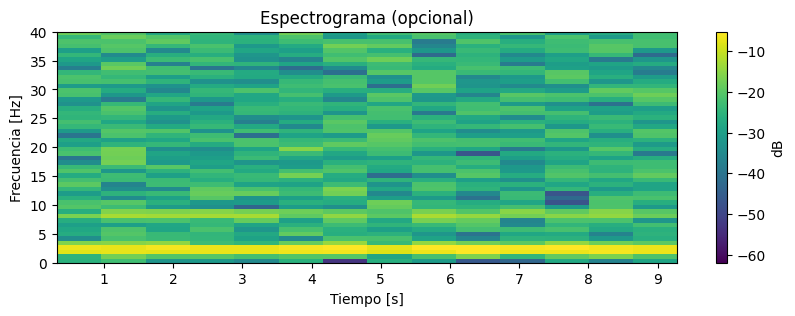

In [7]:
# ---------- 6) (Opcional) Espectrograma ----------
plt.figure(figsize=(10,3))
plt.specgram(x, NFFT=256, Fs=fs, noverlap=128)
plt.xlabel('Tiempo [s]'); plt.ylabel('Frecuencia [Hz]'); plt.title('Espectrograma (opcional)'); plt.colorbar(label='dB')
plt.ylim(0,40)
plt.show()

## Ahora vamos con datos reales....

Vamos con los datos de la meteorología para Cartagena de este año 2025

|#	|Columna	|Descripción|
| --- | --- | --- |
|1	|time	|Hora|
|2	|temp	|Temperatura|
|3	|dwpt	|Punto de Rocío|
|4	|rhum	|Humedad Relativa|
|5	|prcp	|Precipitación Total|
|6	|snow	|Profundidad de la Nieve|
|7	|wdir	|Dirección del Viento|
|8	|wspd	|Velocidad del Viento|
|9	|wpgt	|Ráfaga de Viento|
|10	|pres	|Presión del Aire|
11	|tsun	|Duración del Sol|
|12	|coco	|Código de Condición Meteorológica|

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv("export_data_meteostat.csv")

In [9]:
df

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2025-01-01 00:00:00,28.7,26.0,32.0,1.0,NaN,NaN,10.6,NaN,1009.3,NaN
1,2025-01-02 00:00:00,27.9,25.0,30.4,3.0,NaN,NaN,8.2,NaN,1009.8,NaN
2,2025-01-03 00:00:00,27.8,24.6,32.0,4.4,NaN,NaN,10.0,NaN,1009.8,NaN
3,2025-01-04 00:00:00,26.8,25.0,30.0,15.6,NaN,NaN,6.8,NaN,1010.4,NaN
4,2025-01-05 00:00:00,26.4,25.0,28.0,2.3,NaN,NaN,7.2,NaN,1010.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...
268,2025-09-26 00:00:00,28.9,26.0,32.0,5.7,NaN,NaN,6.8,NaN,1010.0,NaN
269,2025-09-27 00:00:00,28.7,26.0,32.0,4.3,NaN,NaN,10.2,NaN,1010.0,NaN
270,2025-09-28 00:00:00,28.7,26.0,31.0,1.8,NaN,NaN,7.1,NaN,1010.9,NaN
271,2025-09-29 00:00:00,28.5,26.0,32.0,2.6,NaN,NaN,8.8,NaN,1011.2,NaN


<Axes: >

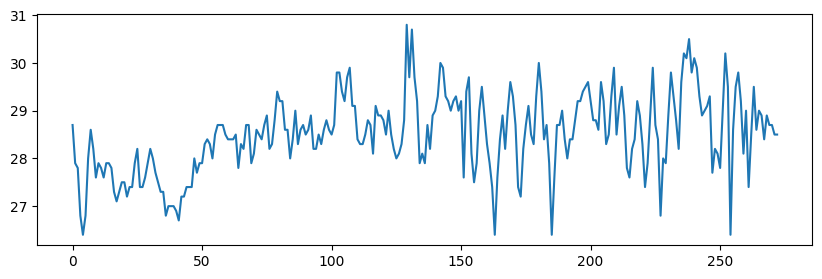

In [10]:
df["tavg"].plot(figsize=(10,3))

### Hagamos el ejercicio con la temperatura 

In [11]:
# ==== Temperatura diaria: Welch + filtro pasa-bajo (fase cero) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# --- 0) Cargar tus datos en df (ya lo tienes). Aseguramos tipos:
# df = ...  # Debe tener columnas: 'date', 'tavg', 'tmin', 'tmax'
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

In [12]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
date,,,,,,,,,,
2025-01-01,28.7,26.0,32.0,1.0,NaN,NaN,10.6,NaN,1009.3,NaN
2025-01-02,27.9,25.0,30.4,3.0,NaN,NaN,8.2,NaN,1009.8,NaN
2025-01-03,27.8,24.6,32.0,4.4,NaN,NaN,10.0,NaN,1009.8,NaN
2025-01-04,26.8,25.0,30.0,15.6,NaN,NaN,6.8,NaN,1010.4,NaN
2025-01-05,26.4,25.0,28.0,2.3,NaN,NaN,7.2,NaN,1010.5,NaN


In [13]:
# --- 1) Construir serie de temperatura (tavg con respaldo):
temp = df['tavg'].copy()
if temp.isna().any():
    # usar promedio de tmin/tmax cuando falte tavg
    aux = df[['tmin','tmax']].mean(axis=1)
    temp = temp.fillna(aux)
# relleno suave de huecos cortos
temp = temp.interpolate(limit=7)

In [14]:
# --- 2) Parámetros de muestreo (diario)
# Frecuencia de muestreo en "ciclos por día" (cpd)
fs = 1.0   # 1 muestra por día
ts = 1/fs
t = np.arange(len(temp)) * ts  # eje de tiempo en días

In [15]:
# --- 3) Preprocesado para análisis espectral
x = temp.values.astype(float)
x = x - np.nanmean(x)               # demean
x = signal.detrend(x, type='linear')# detrend
win = signal.windows.hann(len(x))   # solo para la FFT "de muestra"
xw = x * win

In [16]:
# --- 4) Welch (PSD) en ciclos/día
nperseg = 128 if len(x) >= 256 else max(32, len(x)//4)
f, Pxx = signal.welch(x, fs=fs, nperseg=nperseg, window='hann')

# ignorar f=0 (tendencia) y frecuencias por encima de Nyquist=0.5 cpd
mask = (f > 0) & (f <= 0.5)
f_use, P_use = f[mask], Pxx[mask]

# Pico dominante y período en días
idx_pk = np.argmax(P_use)
f0 = f_use[idx_pk]                # cpd
T0_days = 1.0 / f0                # días por ciclo
print(f"Frecuencia dominante (Welch): {f0:.4f} cpd  →  Período ≈ {T0_days:.2f} días")

Frecuencia dominante (Welch): 0.0078 cpd  →  Período ≈ 128.00 días


In [17]:
# --- 5) Filtro pasa-bajo (fase cero) para suavizar < 1/14 cpd $\sim$ 2 semanas
# Puedes ajustar fc según lo que quieras conservar (p.ej., 1/7 para semanal).
fc = 1/14   # cpd (corte $\sim$ 14 días)
Wn = fc / (fs/2)   # normalizado por Nyquist (0.5 cpd)
Wn = min(max(Wn, 1e-4), 0.999)   # sanidad numérica
b, a = signal.butter(N=4, Wn=Wn, btype='low')
y = signal.filtfilt(b, a, x)

# Welch después de filtrar
f2, P2 = signal.welch(y, fs=fs, nperseg=nperseg, window='hann')

In [18]:
# --- 6) Métrica SNR simple alrededor del pico (± una banda)
band = 0.05   # cpd de ancho alrededor del pico (ajustable)
in_band = (f >= f0-band) & (f <= f0+band)
S_sig = np.trapz(Pxx[in_band], f[in_band]) if in_band.any() else np.nan
S_noise = np.trapz(Pxx[$\sim$in_band], f[$\sim$in_band]) if ($\sim$in_band).any() else np.nan
SNR = S_sig / S_noise
print(f"SNR (±{band} cpd alrededor de f0): {SNR:.2f}")

SyntaxError: invalid syntax (1824782592.py, line 5)

In [ ]:
# --- 7) Gráficas
plt.figure(figsize=(11,6))

# (a) Tiempo
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, temp, label='Temp cruda (tavg)', alpha=0.65)
ax1.plot(df.index, pd.Series(y + np.nanmean(temp), index=df.index),
         label='Suavizada (low-pass, $\sim$14 días)', linewidth=2)
ax1.set_title('Temperatura diaria: cruda vs. suavizada')
ax1.set_ylabel('°C'); ax1.legend(); ax1.grid(True)

# (b) Espectro (Welch)
ax2 = plt.subplot(2,1,2)
ax2.semilogy(f, Pxx, label='PSD cruda (Welch)')
ax2.semilogy(f2, P2, label='PSD suavizada (Welch)')
fc = 1/14  # cpd
ax2.axvline(fc, color='k', ls='--', lw=1, alpha=0.8, label='Corte fc = 1/14 cpd (~14 d)')
ax2.fill_betweenx([P2.min(), Pxx.max()], fc, 0.5, alpha=0.08, color='k')  # zona atenuada
ax2.legend()
ax2.axvline(f0, ls='--', alpha=0.7)
ax2.set_xlim(0, 0.3)  # hasta Nyquist (0.5 cpd)
ax2.set_xlabel('Frecuencia [ciclos/día]'); ax2.set_ylabel('PSD')
ax2.set_title('Espectro (Welch)')
ax2.legend(); ax2.grid(True)
plt.tight_layout(); plt.show()

# (Opcional) Mostrar el período en semanas si tiene sentido:
print(f"Período dominante ≈ {T0_days:.2f} días ({T0_days/7:.2f} semanas).")

# Lectura del resultado con datos reales (temperatura diaria)

## Hallazgo principal
- **Pico espectral (Welch)** en **$f_0 \approx 0.0078\ \text{ciclos/día}$**  
  ⇒ **Período dominante $T_0 \approx 128\ \text{días}$** (≈ 18.3 semanas).

**Interpretación física:** ese período es **sub-estacional** y suele reflejar la transición húmedo–seco / cambios de régimen sinóptico (p. ej., fase de la ZCIT, ondas intraestacionales, ENSO local).  
No vemos ciclo **diurno** porque trabajamos con **promedios diarios** (el ciclo de 1 cpd desaparece al promediar). Un patrón **semanal** en temperatura tampoco suele ser fuerte.

---

## Cómo leer las dos figuras

### 1) Tiempo: cruda vs. suavizada
- La curva **suavizada** (pasa-bajo de $\sim$14 días, sin desfase por `filtfilt`) resalta la **variabilidad intra-estacional** y elimina oscilaciones día a día.  
- Los **valles/crestas** amplios (1–4 meses) coinciden con el pico a $\sim$128 días detectado por Welch.

### 2) Espectro (Welch)
- **Eje x**: frecuencia (ciclos/día); **Eje y**: PSD (potencia).  
- El **pico** cerca de 0.008 cpd confirma un modo de baja frecuencia (meses).  
- La curva **naranja** (tras filtrar) cae fuerte en frecuencias >$\sim$0.05 cpd ⇒ el filtro **atenuó** la alta frecuencia, preservando la energía de baja frecuencia.

---

## ¿Por qué no vemos 1 día o 7 días?
- **Diurno (1 cpd)**: se borra al usar **datos diarios**. Para verlo, necesitas **datos horarios**.  
- **Semanal ($\sim$0.14 cpd)**: en temperatura, suele ser débil; si existe, queda enmascarado por la variabilidad meteorológica y la señal sub-estacional.

---

## Siguiente paso (si queremos “patrones más rápidos” con diarios)
1. **Quitar la tendencia estacional** (STL o media móvil de 30–60 días) y volver a aplicar Welch a las **anomalías**.  
2. Comparar con **viento/presión**: **correlación cruzada** o **coherencia** espectral para ver si comparten bandas.

> Mini-receta (anomalías) para repetir Welch:
> ```python
> from statsmodels.tsa.seasonal import STL
> s = pd.Series(temp.values, index=df.index)
> stl = STL(s, period=60, robust=True).fit()   # $\sim$2 meses como “estacional”
> anomalies = s - stl.trend                     # o s - stl.seasonal - stl.trend
> # Repetir: demean+detrend → Welch sobre 'anomalies'
> ```

---

## Conclusión breve para el informe
- La **temperatura diaria** de 2025 muestra una **oscilación sub-estacional** marcada con **$T_0 \sim 4$ meses**, coherente con la variabilidad regional.  
- El **pasa-bajo** de 14 días mejora la **SNR** de esa componente sin introducir desfase.  
- Para estudiar ciclos **diurnos**, cambiaremos a **datos horarios**; para explorar señales **semanales/intra-mensuales** con diarios, usaremos **anomalías** (STL) antes del análisis espectral.


In [ ]:
fs = 1.0  # cpd
NFFT = 128      # ~128 días de ventana → Δf ≈ fs/NFFT ≈ 0.0078 cpd
noverlap = 96   # 75% solape aprox.

plt.figure(figsize=(10,3))
Pxx, freqs, bins, im = plt.specgram(x, NFFT=NFFT, Fs=fs, noverlap=noverlap, cmap='viridis')
plt.ylim(0, 0.2)  # hasta 0.2 cpd (periodos ≥ 5 d)
plt.xlabel('Tiempo [días]'); plt.ylabel('Frecuencia [cpd]'); plt.title('Espectrograma (diarios)')
plt.colorbar(label='dB'); plt.show()